# Tiny ImageNet Classification

# Step 1. Import Necessary Packages

In [373]:
from PIL import Image
import numpy as np
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adadelta
from keras.regularizers import l2
from keras.utils import np_utils

# Step 2. Read Labels
* `words`: dictionary to look up the labels
* `wnids`: contains the labels given in training data

In [374]:
words = open('words.txt').readlines()
for i in range(len(words)):
    words[i] = words[i][:-1].split('\t')
    
wnids = open('wnids.txt').readlines()
for i in range(len(wnids)):
    wnids[i] = wnids[i][:-1]
    
words = dict(words)

* Following are the labels given in the training data

In [375]:
for i in range(len(wnids)):
    print(wnids[i], words[wnids[i]], sep=' ')

n02124075 Egyptian cat
n04067472 reel
n04540053 volleyball
n04099969 rocking chair, rocker
n07749582 lemon
n01641577 bullfrog, Rana catesbeiana
n02802426 basketball
n09246464 cliff, drop, drop-off
n07920052 espresso
n03970156 plunger, plumber's helper
n03891332 parking meter
n02106662 German shepherd, German shepherd dog, German police dog, alsatian
n03201208 dining table, board
n02279972 monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
n02132136 brown bear, bruin, Ursus arctos
n04146614 school bus
n07873807 pizza, pizza pie
n02364673 guinea pig, Cavia cobaya
n04507155 umbrella
n03854065 organ, pipe organ
n03838899 oboe, hautboy, hautbois
n03733131 maypole
n01443537 goldfish, Carassius auratus
n07875152 potpie
n03544143 hourglass
n09428293 seashore, coast, seacoast, sea-coast
n03085013 computer keyboard, keypad
n02437312 Arabian camel, dromedary, Camelus dromedarius
n07614500 ice cream, icecream
n03804744 nail
n04265275 space heater
n02963159 cardigan
n02486410 baboon
n

In [376]:
def determineLabels():

    wnids = open('wnids.txt').readlines()
    for i in range(len(wnids)):
        wnids[i] = wnids[i][:-1]

    count_dict = {};

    # create training data
    for i in range(len(wnids)):

        # open box data
        train_box = open('train/{0}/{0}_boxes.txt'.format(wnids[i])).readlines()
        for j in range(len(train_box)):
            train_box[j] = train_box[j][:-1].split('\t')

        count_small = 0
        count_big = 0
        for k in range(500):

            # add labels & boxes
            # Y1_train.append(labels[i])
            box = list(map(int, train_box[k][1:]))
            
            if box[2] - box[0] < 15 or box[3] - box[1] < 15:
                count_small += 1
                
            if 30 < box[2] - box[0] and 30 < box[3] - box[1]:
                count_big += 1
        
        count_dict["{0}:{1}".format(wnids[i], words[wnids[i]])] = (count_small, count_big)
                
    return count_dict

In [377]:
count_dict = determineLabels()

In [378]:
sorted(count_dict.items(), key=lambda tup: tup[1][1], reverse=True)[:20]

[('n02791270:barbershop', (3, 488)),
 ('n03014705:chest', (2, 484)),
 ("n04275548:spider web, spider's web", (5, 479)),
 ('n02963159:cardigan', (1, 476)),
 ('n02927161:butcher shop, meat market', (13, 472)),
 ('n02124075:Egyptian cat', (1, 470)),
 ('n06596364:comic book', (13, 468)),
 ('n02123394:Persian cat', (2, 465)),
 ('n07875152:potpie', (0, 460)),
 ('n07873807:pizza, pizza pie', (5, 459)),
 ('n03089624:confectionery, confectionary, candy store', (26, 455)),
 ('n04398044:teapot', (7, 453)),
 ('n01917289:brain coral', (4, 449)),
 ('n01742172:boa constrictor, Constrictor constrictor', (4, 447)),
 ('n02123045:tabby, tabby cat', (4, 446)),
 ('n04070727:refrigerator, icebox', (8, 446)),
 ('n03980874:poncho', (0, 444)),
 ('n04099969:rocking chair, rocker', (5, 443)),
 ('n03393912:freight car', (8, 440)),
 ('n01984695:spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
  (4, 437))]

In [379]:
sorted(count_dict.items(), key=lambda tup: tup[1][0])[:20]

[('n07875152:potpie', (0, 460)),
 ('n02730930:apron', (0, 406)),
 ('n03980874:poncho', (0, 444)),
 ('n02124075:Egyptian cat', (1, 470)),
 ('n02963159:cardigan', (1, 476)),
 ('n03014705:chest', (2, 484)),
 ('n02123394:Persian cat', (2, 465)),
 ('n02791270:barbershop', (3, 488)),
 ('n03404251:fur coat', (4, 395)),
 ('n02123045:tabby, tabby cat', (4, 446)),
 ('n01984695:spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
  (4, 437)),
 ('n03977966:police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
  (4, 429)),
 ('n01917289:brain coral', (4, 449)),
 ('n01742172:boa constrictor, Constrictor constrictor', (4, 447)),
 ('n04099969:rocking chair, rocker', (5, 443)),
 ('n07873807:pizza, pizza pie', (5, 459)),
 ("n04275548:spider web, spider's web", (5, 479)),
 ('n02281406:sulphur butterfly, sulfur butterfly', (5, 364)),
 ('n02666196:abacus', (5, 397)),
 ('n02125311:cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
  (6, 422))]

# Data Preprocessing
* `X_train`: training images / `Y1_train`: labels / `Y2_train`: box coordinates
* `X_val`, `Y1_val`, `Y2_val`: validation set (This will be used to compare models)
* `X_test`, `Y1_test`, `Y2_test`: test set (This will be used to evaluate the final model)

* `labels`: contains the labels that will be used

### `readTrainAndValData()`

In [380]:
def readTrainAndValData():

    wnids = open('wnids.txt').readlines()
    for i in range(len(wnids)):
        wnids[i] = wnids[i][:-1]

    labels = wnids[:10]

    X_train = [] ; Y1_train = [] ; Y2_train = []
    X_val = []   ; Y1_val = []   ; Y2_val = []

    # create training data
    for i in range(len(labels)):

        # open box data
        train_box = open('train/{0}/{0}_boxes.txt'.format(labels[i])).readlines()
        for j in range(len(train_box)):
            train_box[j] = train_box[j][:-1].split('\t')

        for k in range(450):

            # add labels & boxes
            Y1_train.append(i)
            Y2_train.append(list(map(int, train_box[k][1:])))

            # open image
            filename = 'train/{0}/images/{0}_{1}.jpeg'.format(labels[i], k)
            im = np.asarray(Image.open(filename))
            if im.shape == (64,64,3):
                X_train.append(im)
            elif im.shape == (64,64):
                X_train.append(np.dstack([im,im,im]))
            else:
                print('something wrong with {}'.format(filename))

        for l in range(50):

            # add labels & boxes
            Y1_val.append(i)
            Y2_val.append(list(map(int, train_box[l+450][1:])))

            # open image
            filename = 'train/{0}/images/{0}_{1}.jpeg'.format(labels[i], l+450)
            im = np.asarray(Image.open(filename))
            if im.shape == (64,64,3):
                X_val.append(im)
            elif im.shape == (64,64):
                X_val.append(np.dstack([im,im,im]))
            else:
                print('something wrong with {}'.format(filename))


    X_train = np.stack(X_train, axis=0)
    Y1_train = np_utils.to_categorical(Y1_train, 10)
    Y2_train = np.stack(Y2_train, axis=0)

    X_val = np.stack(X_val, axis=0)
    Y1_val = np_utils.to_categorical(Y1_val, 10)
    Y2_val = np.stack(Y2_val, axis=0)
    
    return X_train, Y1_train, Y2_train, X_val, Y1_val, Y2_val, labels

### `readTestData()`

In [19]:
def readTestData(labels):

    # create test data
    X_test = []  ; Y1_test = []  ; Y2_test = []

    val_annot = open('val/val_annotations.txt').readlines()
    for i in range(len(val_annot)):
        val_annot[i] = val_annot[i][:-1].split('\t')

    for i in range(len(val_annot)):

        if val_annot[i][1] in labels:
            filename = 'val/images/val_{0}.jpeg'.format(i)
            im = np.asarray(Image.open(filename))

            # Y1_test.append(val_annot[i][1])
            Y1_test.append(labels.index(val_annot[i][1]))
            Y2_test.append(list(map(int, val_annot[i][2:])))

            if im.shape == (64,64,3):
                X_test.append(im)
            elif im.shape == (64,64):
                X_test.append(np.dstack([im,im,im]))
            else:
                print('something wrong with {}'.format(filename))

    X_test = np.stack(X_test, axis=0)
    Y1_test = np_utils.to_categorical(Y1_test, 10)
    Y2_test = np.stack(Y2_test, axis=0)
    
    return X_test, Y1_test, Y2_test

# Data Augmentation

## 1. `dataAugmentation1(X_train, Y1_train, Y2_train)`
* translate images in one direction (-x, +x, -y, or +y)

### The following code shows how images can be shifted in one direction

In [402]:
Y2_train[16]

array([ 0, 20, 48, 63])

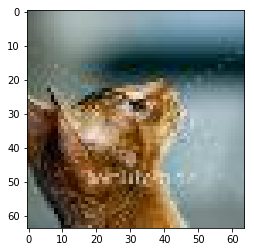

In [403]:
plt.imshow(X_train[16])

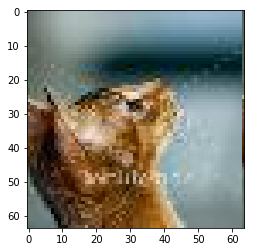

In [434]:
#moving in -x direction
Xtemp = np.delete(X_train[16], 0, 1)
Xtemp2 = np.hstack([Xtemp, X_train[16][:,0:1,:]])

plt.imshow(Xtemp2)

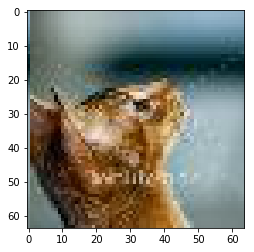

In [435]:
#moving in +x direction
Xtemp = np.delete(X_train[16], -1, 1)
Xtemp2 = np.hstack([X_train[16][:,-1:,:], Xtemp])

plt.imshow(Xtemp2)

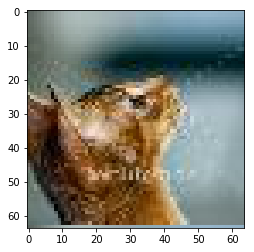

In [432]:
#moving in -y direction
Xtemp = np.delete(X_train[16], 0, 0)
Xtemp2 = np.vstack([Xtemp, X_train[16][0:1,:,:]])

plt.imshow(Xtemp2)

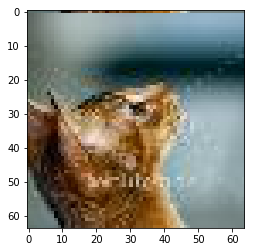

In [433]:
#moving in +y direction
Xtemp = np.delete(X_train[16], -1, 0)
Xtemp2 = np.vstack([X_train[16][-1:,:,:], Xtemp])

plt.imshow(Xtemp2)

### Implemented Function

In [ ]:
def translateImage(image, direction):

    if direction == "-x":
        # moving in -x direction
        Xtemp = np.delete(X_train[16], 0, 1)
        return np.hstack([Xtemp, X_train[16][:,0:1,:]])
    
    elif direction == "+x"
        # moving in +x direction
        Xtemp = np.delete(X_train[16], -1, 1)
        return np.hstack([X_train[16][:,-1:,:], Xtemp])
    
    elif direction == "-y"
        # moving in -y direction
        Xtemp = np.delete(X_train[16], 0, 0)
        return np.vstack([Xtemp, X_train[16][0:1,:,:]])
        
    elif direction == "+y"
        #moving in +y direction
        Xtemp = np.delete(X_train[16], -1, 0)
        return np.vstack([X_train[16][-1:,:,:], Xtemp])

def dataAugmentation1(X_train, Y1_train, Y2_train):

    X_temp = [] ; Y2_temp = []

    for i in range(len(X_train)):

        if Y2_train[i][0] > 0:
            X_temp.append(translateImage(X_train[i], "-x"))
            Y2_temp.append(Y2_train[i] + np.array([-1, 0, -1, 0]))
            
        elif Y2_train[i][2] < 63:
            X_temp.append(translateImage(X_train[i], "+x"))
            Y2_temp.append(Y2_train[i] + np.array([+1, 0, +1, 0]))
            
        elif Y2_train[i][1] > 0:
            X_temp.append(translateImage(X_train[i], "-y"))
            Y2_temp.append(Y2_train[i] + np.array([0, -1, 0, -1]))
            
        elif Y2_train[i][3] < 63:
            X_temp.append(translateImage(X_train[i], "+y"))
            Y2_temp.append(Y2_train[i] + np.array([0, +1, 0, +1]))
            
        else:
            X_temp.append(X_train[i])
            Y2_temp.append(Y2_train[i])            
        
    X_temp = np.stack(X_temp, axis=0)
    Y2_temp = np.stack(Y2_temp, axis=0)
    
    return X_temp, Y1_train, Y2_temp

## 2. `dataAugmentation2(X_train, Y1_train, Y2_train)`
* Flips the image horizontally, change the box coordinates accordingly

### The following code shows how an image can be flipped horizontally

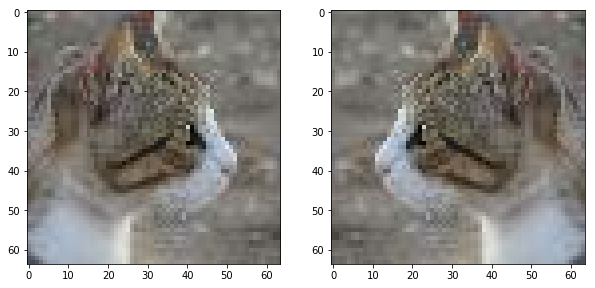

In [153]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(X_train[0])

plt.subplot(1,2,2)
plt.imshow(np.flip(X_train, 2)[0])

In [40]:
np.concatenate([X_train, np.flip(X_train, 2)], axis=0).shape

(9000, 64, 64, 3)

In [41]:
np.concatenate([Y1_train, Y1_train], axis=0).shape

(9000, 10)

In [33]:
np.concatenate(np.split(Y2_train, 4, axis=1), axis=0).shape

(4500, 4)

### Implemented Function

In [ ]:
def dataAugmentation2(X_train, Y1_train, Y2_train):

    # flip the images horizontally
    X_temp = np.concatenate([X_train, np.flip(X_train, 2)], axis=0)
    Y1_temp = np.concatenate([Y1_train, Y1_train], axis=0)
    
    Y2 = np.split(Y2_train, 4, axis=1)
    Y2_temp = np.concatenate([ 64-Y2[2] , Y2[1], 64-Y2[0], Y2[3] ], axis=0)
    
    return X_temp, Y1_train, Y2_temp

## 3. `dataAugmentation3(X_train, Y1_train, Y2_train)`
* randomly shuffles pixels outside the box

### The following code shows how the pixels outside the box can be shuffled

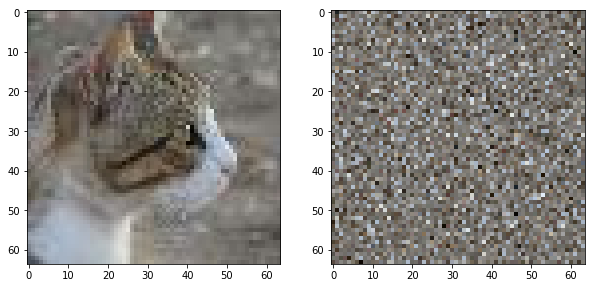

In [152]:
# deep copy, so that original data is not shuffled
test_image = X_train[0].copy()

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(test_image)

plt.subplot(1,2,2)
# if the images are not reshaped, only the rows will be shuffled
test2 = test_image.reshape(64*64,3)
np.random.shuffle(test2)
test2 = test2.reshape(64,64,3)
plt.imshow(test_image)

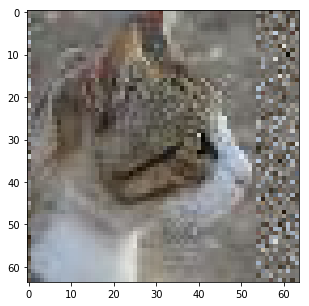

In [155]:
A = np.array([False]*Y2_train[0][0] + [True]*(Y2_train[0][2]-Y2_train[0][0]+1) + [False]*(63-Y2_train[0][2]))
A = np.stack([A]*64, axis=0).reshape(64,64,1)

B = np.array([False]*Y2_train[0][1] + [True]*(Y2_train[0][3]-Y2_train[0][1]+1) + [False]*(63-Y2_train[0][3]))
B = np.stack([B]*64, axis=1).reshape(64,64,1)

AB = np.dstack([A*B,A*B,A*B])

plt.figure(figsize=(5,5))
plt.imshow(np.where(AB == True, AB*X_train[0], test2))

### Implemented Function

In [ ]:
def dataAugmentation3(X_train, Y1_train, Y2_train):

    X_temp = []

    for i in range(len(X_train)):
        
        # deep copy, so that original data is not shuffled
        temp = X_train[0].copy()

        # if the images are not reshaped, only the rows will be shuffled
        temp = temp.reshape(64*64,3)
        np.random.shuffle(temp)
        temp = temp.reshape(64,64,3)
        
        A = np.array([False]*Y2_train[i][0] + [True]*(Y2_train[i][2]-Y2_train[i][0]+1) + [False]*(63-Y2_train[i][2]))
        A = np.stack([A]*64, axis=0).reshape(64,64,1)

        B = np.array([False]*Y2_train[i][1] + [True]*(Y2_train[i][3]-Y2_train[i][1]+1) + [False]*(63-Y2_train[i][3]))
        B = np.stack([B]*64, axis=1).reshape(64,64,1)

        # to change the shape from 64*64*1 to 64*64*3
        AB = np.dstack([A*B,A*B,A*B])
        X_temp.append(np.where(AB == True, AB*X_train[0], test2))
        
    X_temp = np.stack(X_temp, axis=0)
        
    return X_temp, Y1_train, Y2_train

In [ ]:
def dataAugmentation(X_train, Y1_train, Y2_train):
    
    X_aug1, Y1_aug1, Y2_aug1 = dataAugmentation1(X_train, Y1_train, Y2_train)
    X_aug2, Y1_aug2, Y2_aug2 = dataAugmentation2(X_train, Y1_train, Y2_train)
    X_aug3, Y1_aug3, Y2_aug3 = dataAugmentation3(X_train, Y1_train, Y2_train)

    X_aug = np.concatenate([X_aug1, X_aug2, X_aug3], axis=0)
    Y1_aug = np.concatenate([Y1_aug1, Y1_aug2, Y1_aug3], axis=0)
    Y2_aug = np.concatenate([Y2_aug1, Y2_aug2, Y2_aug3], axis=0)
    
    return X_aug, Y1_aug, Y2_aug

# 4. Models

## 4.1. Model 1

In [12]:
model1 = Sequential()
model1.add(Conv2D(4, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_initializer="glorot_uniform"))
model1.add(Conv2D(4, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_initializer="glorot_uniform"))
model1.add(Conv2D(4, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_initializer="glorot_uniform"))
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(10, activation='softmax', kernel_initializer="glorot_uniform"))

np.random.seed(0)
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adadelta())

In [13]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 4)         112       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 4)         148       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 4)         148       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3364)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                33650     
Total params: 34,058
Trainable params: 34,058
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
hist1 = model1.fit(X_train, Y1_train, epochs=10, batch_size=30, validation_data=(X_val, Y1_val), verbose=2)

Train on 4500 samples, validate on 500 samples
Epoch 1/10
 - 12s - loss: 3.0036 - acc: 0.1189 - val_loss: 2.3145 - val_acc: 0.1220
Epoch 2/10
 - 11s - loss: 2.2273 - acc: 0.1649 - val_loss: 2.3168 - val_acc: 0.1520
Epoch 3/10
 - 11s - loss: 2.0749 - acc: 0.2378 - val_loss: 2.3705 - val_acc: 0.1560
Epoch 4/10
 - 11s - loss: 1.9101 - acc: 0.3131 - val_loss: 2.5104 - val_acc: 0.1560
Epoch 5/10
 - 11s - loss: 1.7551 - acc: 0.3773 - val_loss: 2.7669 - val_acc: 0.1760
Epoch 6/10
 - 11s - loss: 1.6051 - acc: 0.4336 - val_loss: 2.8874 - val_acc: 0.1720
Epoch 7/10
 - 12s - loss: 1.4654 - acc: 0.4816 - val_loss: 3.2344 - val_acc: 0.1720
Epoch 8/10
 - 12s - loss: 1.3370 - acc: 0.5351 - val_loss: 3.4294 - val_acc: 0.1680
Epoch 9/10
 - 11s - loss: 1.2246 - acc: 0.5764 - val_loss: 3.5459 - val_acc: 0.1920
Epoch 10/10
 - 12s - loss: 1.1149 - acc: 0.6129 - val_loss: 3.7518 - val_acc: 0.1600
CPU times: user 4min 24s, sys: 22.3 s, total: 4min 46s
Wall time: 1min 54s


In [ ]:
plt.plot(hist1.history['acc'], 'b-', label="training")
plt.plot(hist1.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

In [ ]:
model1.save("mnist_cnn11.hdf5")

In [ ]:
plt.plot(hist2.history['acc'], 'b-', label="training")
plt.plot(hist2.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()